## Initial hierarchical analysis

In [1]:
#pip install cmdstanpy

DEPRECATION: Loading egg at /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/jupyter-1.0.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /Library/Frameworks/Python.framework/Versions/3.11/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
#pip install -e git+https://github.com/stan-dev/cmdstanpy@develop#egg=cmdstanpy

DEPRECATION: Loading egg at /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/jupyter-1.0.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
Obtaining cmdstanpy from git+https://github.com/stan-dev/cmdstanpy@develop#egg=cmdstanpy
  Updating ./src/cmdstanpy clone (to revision develop)
  Running command git fetch -q --tags
  Running command git reset --hard -q cbea79f3e2f03dfe0f056c30cb613bf30d527750
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for cmdstanpy (pyproject.toml) ... done
  Created wheel for cmdstanpy: filename=cmdstanpy-1.2.2-0.editable-py3-none-any.whl size=5411 sha256=a6

In [37]:
import cmdstanpy as csp

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# for the loss functions
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [38]:
data_all = pd.read_csv("data_mags_5000.csv")

In [39]:
data_all.columns

Index(['template_id', 'median_z', 'mean_z', 'minchi2', 'mode_z', 'z_sigma68',
       'z_sigma', 'z_mc', 'concentration_i', 'concentration_cal_i',
       'asymmetry_i', 'clumpiness_i', 'gini_i', 'm20_i', 'mag_sersic_i',
       'mag_cal_i', 're_sersic_i', 're_cal_i', 'n_sersic_i', 'n_sersic_cal_i',
       'ellipticity_sersic_i', 'ellipticity_sersic_cal_i'],
      dtype='object')

Read in all relevant data columns

In [40]:
# template data
group_id = data_all["template_id"] + 1 # + 1 since python and stan use different indices

# for redshift (less relevant)
median_z = data_all["median_z"]
z_sigma68 = data_all["z_sigma68"]
z_sigma = data_all["z_sigma"]
min_chi_z = data_all["minchi2"] # chi^2 of best fit template type

# galaxy properties
mag_sersic = data_all["mag_sersic_i"]
mag_cal = data_all["mag_cal_i"]
concentration = data_all['concentration_i']
asymmetry = data_all['asymmetry_i']
concentration = data_all['concentration_i']
clumpiness = data_all['clumpiness_i']
gini = data_all['gini_i']
m20 = data_all['m20_i']
re_sersic = data_all['re_sersic_i']
concentration = data_all['concentration_i']

Run the following relationships in the model (y vs x):

- `m20_i` vs magnitude
    - **Use as test dataset for determining priors, data cuts, and pooling amounts**
- Concentration vs magnitude
- Asymmetry vs magnitude
- Clumpiness vs magnitude
- `gini_i` vs magnitude
- Concentration vs `re_sersic_i`
- `gini_i` vs `m20_i` (? from paper)
- Magnitude vs z (unlikely but worth a shot)

In [65]:
# easy way to change the data to run on ONLY CHANGE IT HERE
x_data = mag_sersic
y_data = m20

# change labels for plots and accessing from dataframes
x_label = "mag_sersic_i"
y_label = "m20_i"

In [42]:
# other prior information needed for the model

N = data_all.shape[0] # total number of objects

num_templates = len(np.unique(group_id))

a1 = 1
b1 = 1
a2 = 1
b2 = 1
nu = 3
lambda_var = 1

Not all templates may necessarily be represented in the choosen data set. Due to this, the number of templates may not necessarilly be as large as the maximum group_id value.

In [43]:
# collect data as input for the model into a single variable
data = {'N': N, 
        'J': num_templates,
        'm': np.max(group_id), 
        'y_data': y_data,
        'x_data': x_data,
        'group_id': group_id,
        'a1': a1,
        'b1': b1,
        'a2': a2,
        'b2': b2,
        'nu': nu,
        'lambda': lambda_var,}

In [12]:
#from cmdstanpy import install_cmdstan
#install_cmdstan(verbose=True)

Cannot connect to github.
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:992)>
retry (1/5)
Cannot connect to github.
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:992)>
retry (2/5)
Cannot connect to github.
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:992)>
retry (3/5)
Cannot connect to github.
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:992)>
retry (4/5)
Cannot connect to github.
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:992)>
retry (5/5)


13:18:49 - cmdstanpy - WARNING - CmdStan installation failed.
Cannot connect to CmdStan github repo.


Cannot connect to github.
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:992)>


False

In [44]:
model = csp.CmdStanModel(stan_file = 'hierarchical-regression.stan')
sample = model.sample(data = data, seed = 1, chains = 1,
                      iter_sampling = 1000, iter_warmup = 1000,
                      show_progress = False, show_console = False)

14:08:39 - cmdstanpy - INFO - CmdStan start processing
14:08:39 - cmdstanpy - INFO - Chain [1] start processing
14:11:15 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
# how to save a model
# sample.save_csvfiles("second-run-sigma68/model-data-50000-prior1")

# how to read a saved file
#sample = csp.from_csv("model-data-cut-5000/hierarchical-regression-20240422121707.csv")

In [45]:
alpha_list = sample.stan_variable("alpha")
beta_list = sample.stan_variable("beta")

In [19]:
print(alpha_list.shape)

(5000, 44)


## Loss functions

In [10]:
# define additional loss function methods
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

## Plotting by template type
Group raw data by template ID and assign a color.

Make a line collection of all alphas and betas from each template group. Add in alpha_bar and beta_bar for a global linear fit.

In [48]:
alpha_group = np.array([np.mean(alpha_template) for alpha_template in sample.stan_variable("alpha").transpose()])
beta_group = np.array([np.mean(beta_template) for beta_template in sample.stan_variable("beta").transpose()])
color_map = np.arange(0, data_all["template_id"].max()+1)

In [54]:
# get the global slope and intercept
alpha_bar = np.mean(sample.stan_variable('alpha_bar'))
beta_bar = np.mean(sample.stan_variable('beta_bar'))
print(alpha_bar, beta_bar)

-2.62530433 0.07622404097


In [97]:
xs = np.arange(np.min(x_data), np.max(x_data), np.max(x_data)/1000)
segs = [] # for collection of lines to plot
masked_segs = [] # generate list of linear fits that pass the loss functions
masked_alphas = [] # list of alphas that pass loss funtions
masked_betas = [] # list of betas that pass loss functions

for template_id in range(len(alpha_group)):
    subset = data_all[data_all['template_id']==template_id]
    
    data = alpha_group[template_id] + beta_group[template_id]*xs
    
    segs.append(((xs[0], data[0]), (xs[-1], data[-1])))

    if len(subset) < 10:
        loss_fnc_bool.append(False)
        continue

    predicted = alpha_group[template_id] + beta_group[template_id] * subset[x_label]
    
    # calculate loss functions
    mse_val = mean_squared_error(subset[y_label], predicted)
    r2_val = r2_score(subset[y_label], predicted)

    if (mse_val < 0.7) and (r2_val > 0.25):
        masked_segs.append(((xs[0], data[0]), (xs[-1], data[-1])))
        masked_alphas.append(alpha_group[template_id])
        masked_betas.append(beta_group[template_id])

# append the global linear fit as a single line, with all templates
global_seg = []
global_data = alpha_bar + beta_bar*xs
global_seg.append(((xs[0], global_data[0]), (xs[-1], global_data[-1])))

# append the global linear fit as a single line, with only good templates
masked_global_seg = []
masked_global_data = np.mean(masked_alphas) + np.mean(masked_betas)*xs
masked_global_seg.append(((xs[0], masked_global_data[0]), (xs[-1], masked_global_data[-1])))

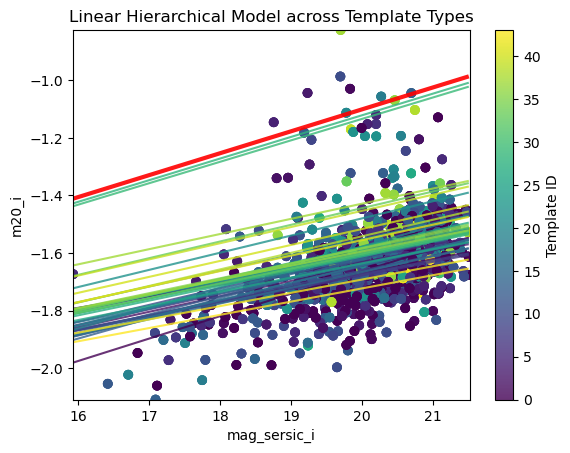

In [96]:
# plot all templates
fig, ax = plt.subplots()
ln_coll = matplotlib.collections.LineCollection(segs, array=color_map, alpha=0.8, linewidths=1.5)
global_ln_coll = matplotlib.collections.LineCollection(global_seg, color='red', alpha=0.9, linewidths=3)

ax.set_xlim(np.min(x_data), np.max(x_data))    
ax.set_ylim(np.min(y_data), np.max(y_data))
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title("Linear Hierarchical Model across Template Types")

ax.add_collection(ln_coll)
ax.add_collection(global_ln_coll)
ax.scatter(x_data, y_data, c=group_id, alpha=0.8)

template_color = fig.colorbar(ln_coll)
template_color.set_label('Template ID')
plt.show()

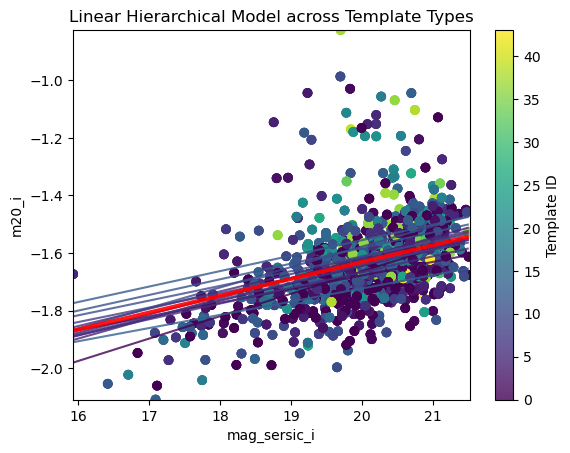

In [98]:
# only plot templates that pass the loss functions
fig, ax = plt.subplots()
ln_coll = matplotlib.collections.LineCollection(masked_segs, array=color_map, alpha=0.8, linewidths=1.5)
global_ln_coll = matplotlib.collections.LineCollection(masked_global_seg, color='red', alpha=0.9, linewidths=3)

ax.set_xlim(np.min(x_data), np.max(x_data))    
ax.set_ylim(np.min(y_data), np.max(y_data))
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title("Linear Hierarchical Model across Template Types")

ax.add_collection(ln_coll)
ax.add_collection(global_ln_coll)
ax.scatter(x_data, y_data, c=group_id, alpha=0.8)

template_color = fig.colorbar(ln_coll)
template_color.set_label('Template ID')
plt.show()

## Introducing magnitudes

In [23]:
mag_ratio = np.abs(mag_cal) / mag_sersic

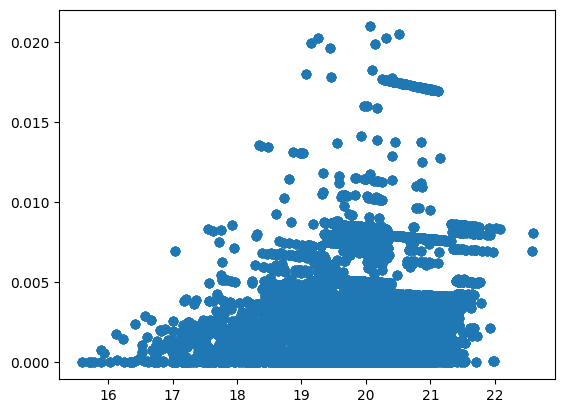

In [24]:
plt.scatter(mag_sersic, mag_ratio)

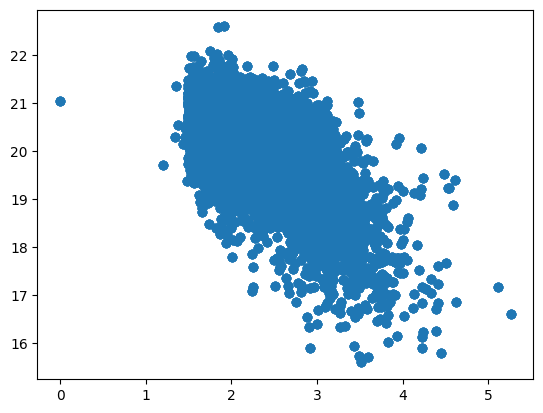

In [32]:
plt.scatter(concentration_i, mag_sersic)

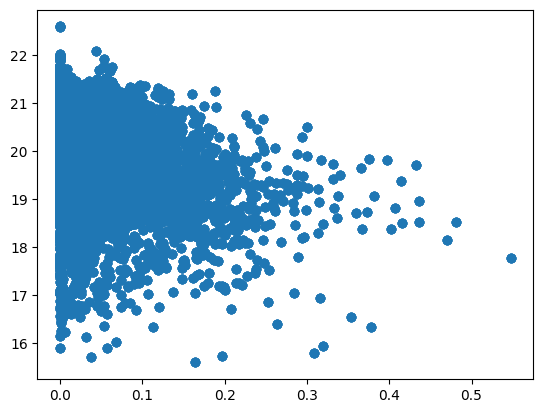

In [31]:
plt.scatter(clumpiness_i, mag_sersic)

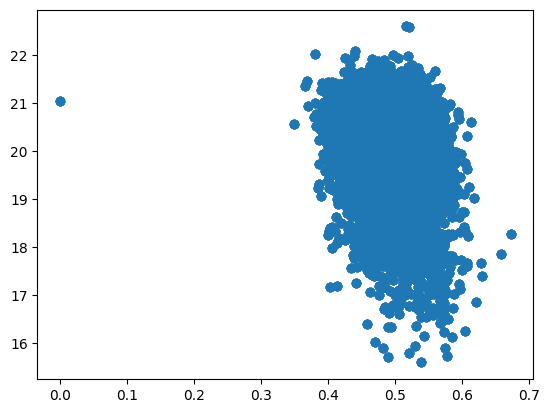

In [30]:
plt.scatter(gini_i, mag_sersic)

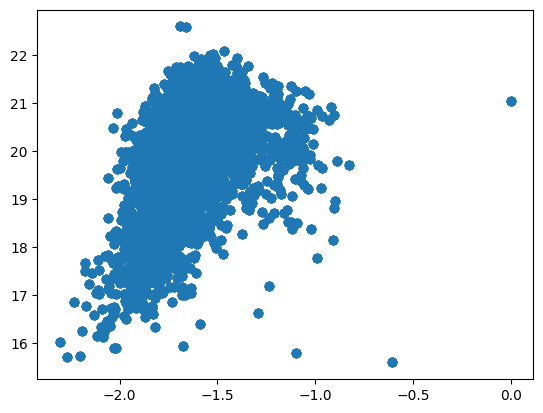

In [33]:
plt.scatter(m20_i, mag_sersic)

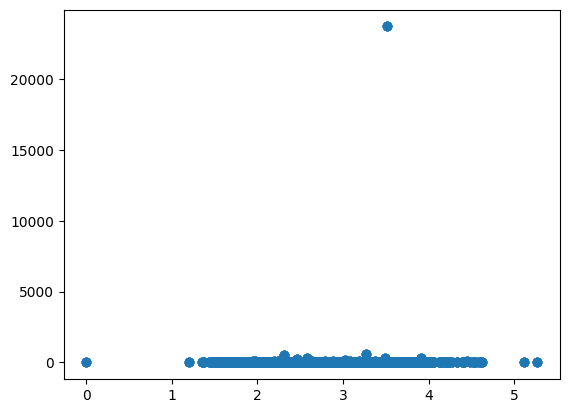

In [34]:
plt.scatter(concentration_i, re_sersic_i)

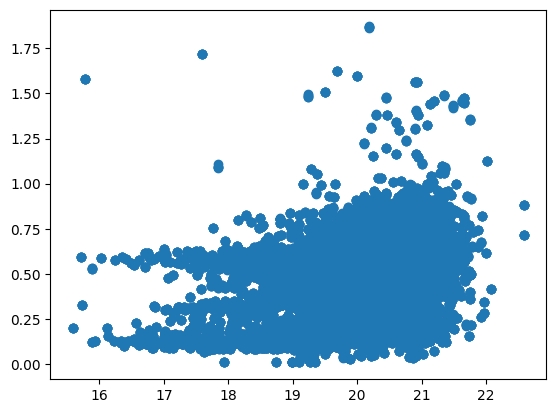

In [35]:
plt.scatter(mag_sersic, median_z)